<a href="https://colab.research.google.com/github/RubingLi123/foster_2023spring/blob/2023sp-master/Module4_Regularization/Regularization_and_learning_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#If opening in colab run this cell
!git clone https://github.com/CTVisMe/DS4B_Sp24.git
%cd DS4B_Sp24/ClassModules/Module4_Regularization/

Cloning into 'DS4B_Sp24'...
remote: Enumerating objects: 807, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 807 (delta 96), reused 208 (delta 96), pack-reused 598
Receiving objects: 100% (807/807), 147.60 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (359/359), done.
Updating files: 100% (139/139), done.
/content/DS4B_Sp24/ClassModules/Module4_Regularization


# Regularization and Learning Curves

Spring 2024 - Instructor:  Chris Volinsky

Teaching Assistants: Aditya Deshpande, Stuti Mishra, Krutika Savani

Original Notebooks courtesy of Prof. Foster Provost and Rubing Li

***

Import all of the packages we will need.

In [2]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

# Our custom libraries!
import sys
sys.path.append("..")
from ds_utils.decision_surface import *

### Complexity control, revisited

Recall that one of the most important fundamental principles underlying data science, the basis for machine learning, is *complexity control*.  We must manage the tension between allowing ourselves to fit complex patterns in the data (a good thing), and the tendency to fit idiosyncracies in a particular data set--things that do not generalize (a bad thing).  So, we attempt to control complexity.  One way to control complexity is just not to allow our data mining procedure to fit complex models in the first place.  That's what we do when we build linear models from small sets of features.  But let's consider the case where we think larger feature sets or non-linearities might add important predictive power--so we will attempt to control complexity in a data-driven fashion.

We will be using concrete data -- really ... data about concrete. The data set consists of several compressive strength tests for various types of concrete.

In [3]:
concrete_url = "https://www.openml.org/data/get_csv/1762521/phpZGl7F2"
concrete_df = pd.read_csv(concrete_url).dropna()
concrete_df.rename(columns={
    "Cement (component 1)(kg in a m^3 mixture)"             : "cement",
    "Blast Furnace Slag (component 2)(kg in a m^3 mixture)" : "slag",
    "Fly Ash (component 3)(kg in a m^3 mixture)"            : "fly_ash",
    "Water  (component 4)(kg in a m^3 mixture)"             : "water",
    "Superplasticizer (component 5)(kg in a m^3 mixture)"   : "superplasticizer",
    "Coarse Aggregate  (component 6)(kg in a m^3 mixture)"  : "coarse_agg",
    "Fine Aggregate (component 7)(kg in a m^3 mixture)"     : "fine_agg",
    "Age (day)"                                             : "age",
    "Concrete compressive strength(MPa. megapascals)"      : "strength"
}, inplace= True)

concrete_df.head(5)

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30


Suppose we want to predict which concrete formulas are strong enough for a particular application we have in mind (say 35 megapascals or more). This would be a binary classification (class-probability estimation) problem.

In [4]:
concrete_df["is_strong"] = concrete_df.strength >= 35
concrete_df = concrete_df.drop("strength", axis="columns")
X = concrete_df.iloc[:, :-1]
Y = concrete_df.is_strong

### Complexity control for logistic regression (regularization)

One way to control the complexity of a model like logistic regression is to limit the number of variables.  There are different ways to do that, including using domain knowledge to select variables, ranking the variables based on some measure of correlation with the target variable (like informatin gain) and choosing the "strongest", and data-driven methods like sequential forward selection, sequential backward elimination, and other intelligent [feature selection](https://en.wikipedia.org/wiki/Feature_selection) methods.

Today we will look at a different way of controlling complexity in mathematical models.  This method ("regularization" via mathematical optimization) is now one of the standard methods used in machine learning: not just for logistic regression, but generally for the large family of modeling methods that fits a parameterized numeric function to data.

Recall that when fitting a logistic regression classifier (and many other models), we try to find the set of weights, $\textbf{w}$, that maximize the fit to the data, based on some fit ("objective") function. In this case, let's call our objective function $g()$, which means that we want: $\arg\max_\textbf{w} g(\textbf{x}, \textbf{w})$.

We are trying to find the best set of weights without too much complexity.  Therefore, when we perform **regularization** we mathematically **penalize** models as they get more complex.  We achieve this by adding a "penalty term" into the objective function.  We moderate how much we care about fit and how much we care about simplicity (lack of complexity) by using a "regularization parameter" $\lambda$ to specify how much importance our optimization procedure should place on fit vs. simplicity:

$\arg\max_\textbf{w} g(\textbf{x}, \textbf{w}) - \lambda \cdot \text{penalty}(\textbf{w})$.

(The regularization parameter also sometimes is represented as `c`, which is usually $\frac{1}{\lambda}$ so smaller values of `c` lead to larger complexity penalties.)

For mathematical reasons, allowing larger weights allows more complex fitting, so most penalties end up penalizing larger weights.

The two most common types of regularization for logistic regression (and beyond) are the so-called $L_1$ and $L_2$ regularizations, which simply use the sum of the absolute value of the weights ($\textbf{w}$) and the sum of the squares of the weights, respectively, as the penalty.


In [5]:
#Let's set ourselves up to build some complex logistic regressions, as we have done in prior classes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def get_polynomial(degree, model):
    # create different powers of X
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("model", model)])
    return pipeline

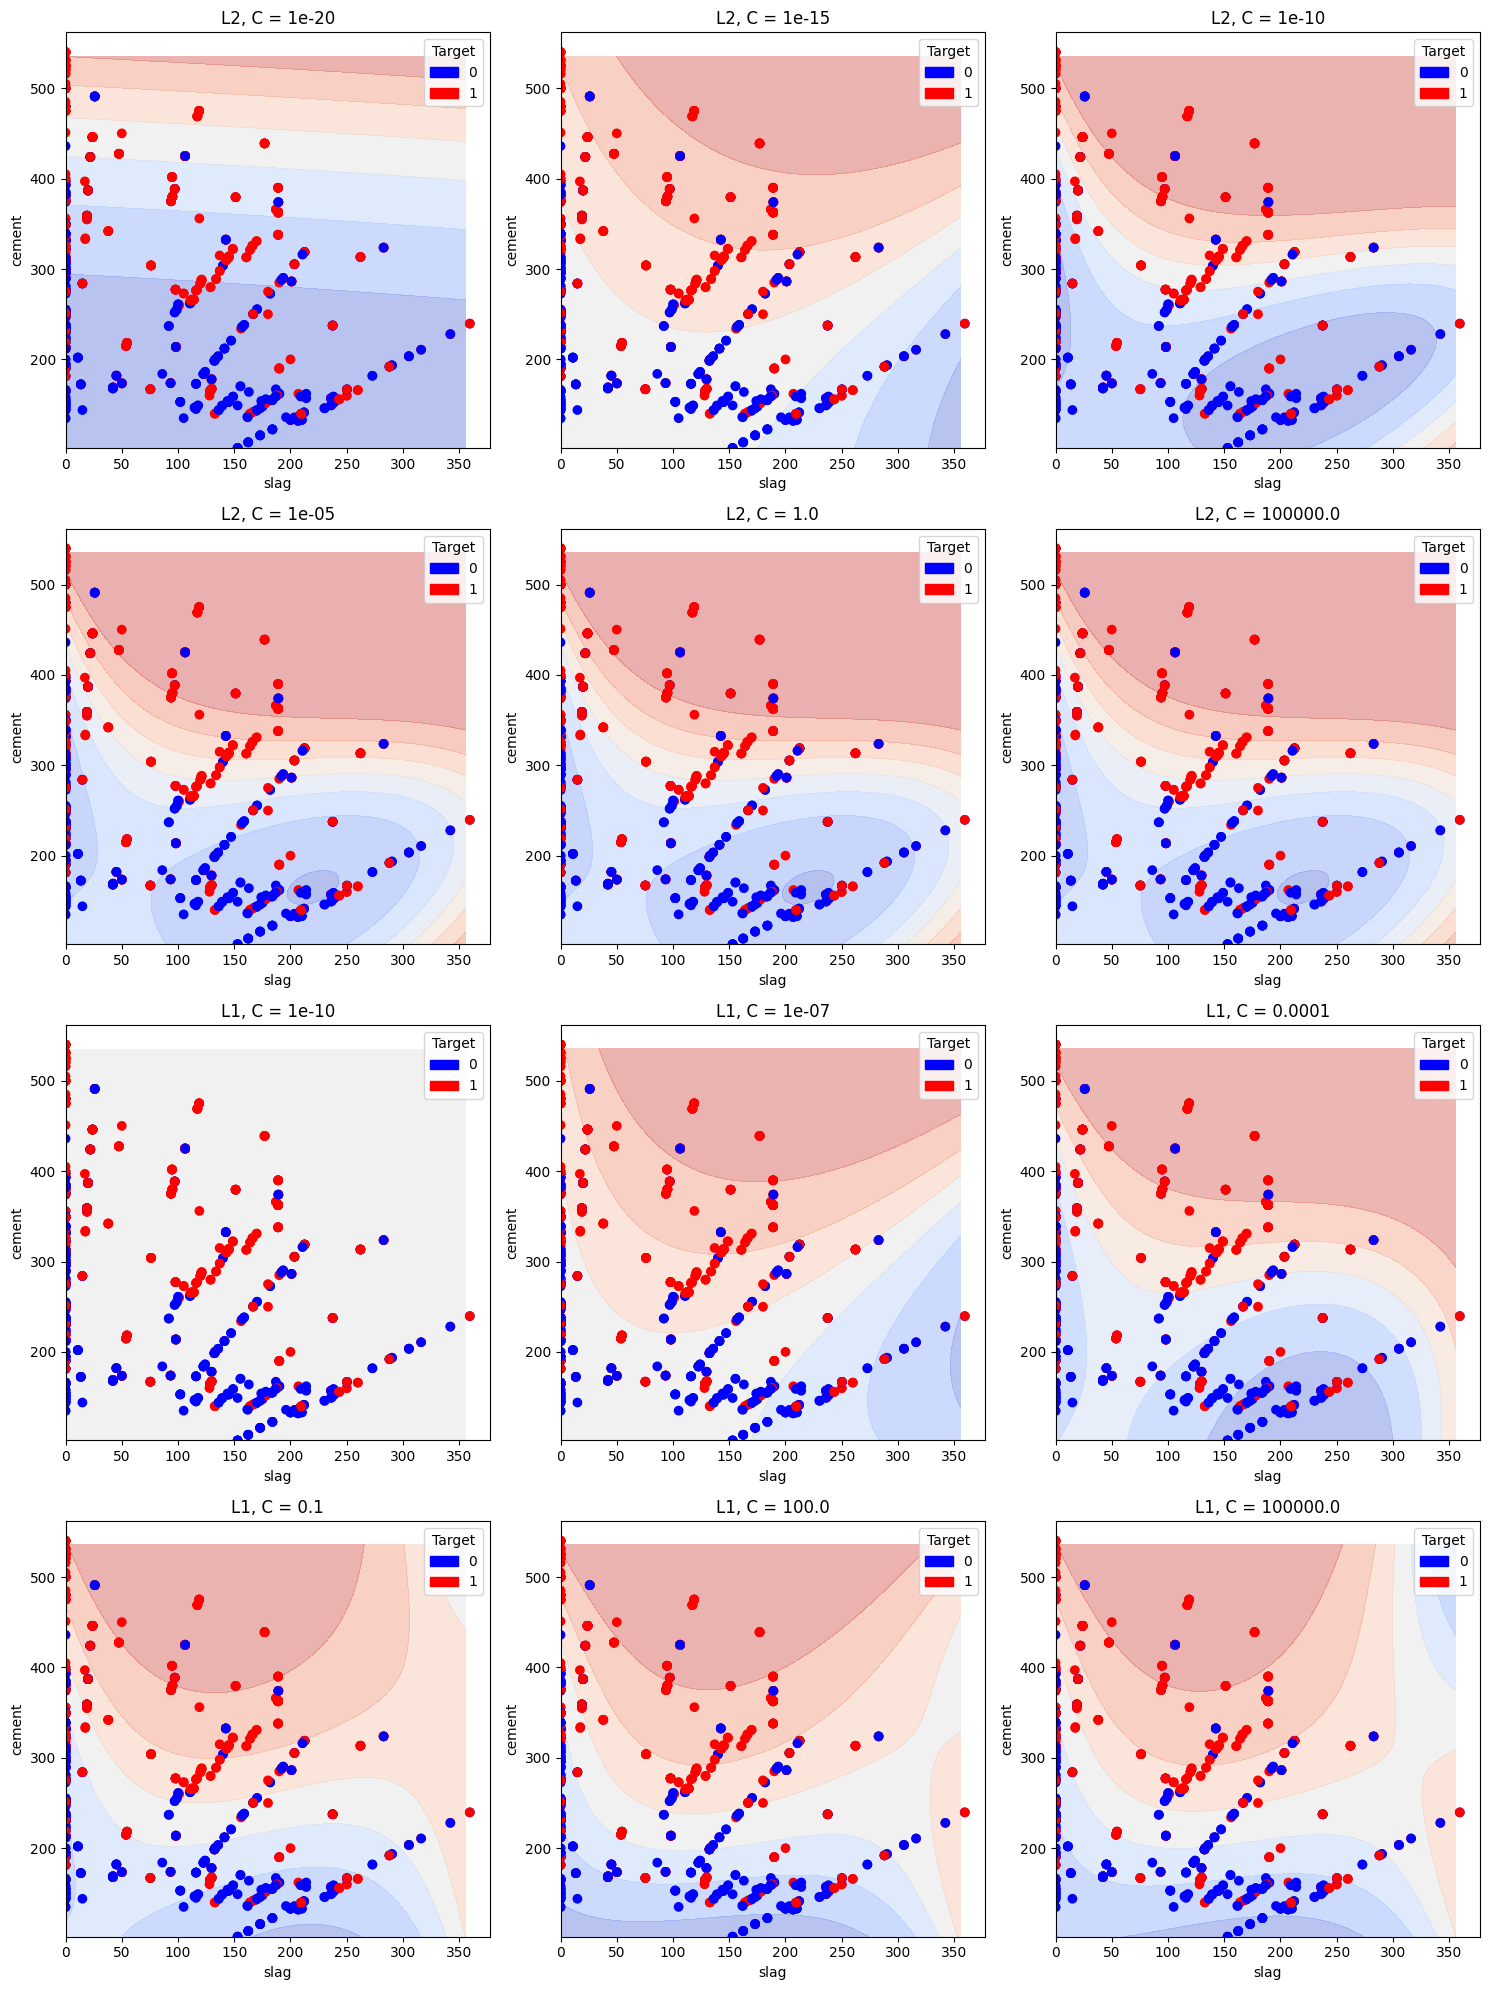

In [6]:
# Let's use 3rd degree polynomial
degree = 3
cs = {"L2": range(-20,6,5), "L1": range(-10,8,3)}
import warnings
warnings.filterwarnings("ignore")
# Plot decision surfaces for different regularization values for L1 and L2 regularization
position = 0
plt.figure(figsize=(15, 20))
for regularization in ['L2', 'L1']:
    # Try some regularization values
    for i in cs[regularization]:
        # Modeling
        c = np.power(10.0, i)
        model = LogisticRegression(penalty=regularization.lower(), C=c, solver='liblinear')
        model = get_polynomial(degree, model)
        # Plotting
        position += 1
        plt.subplot(4, 3, position)
        Decision_Surface(X, "slag", "cement", Y, model, True)
        plt.title(regularization + ", C = " + str(np.power(10.0, i)))
plt.tight_layout()
plt.show()

**Feature weights without regularization.**

In [7]:
def get_coeffs(X, Y, model):
    model.fit(X, Y)
    return dict(zip(X.columns, model.coef_[0]))

pd.DataFrame([get_coeffs(X, Y, LogisticRegression(solver='liblinear'))])

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
0,0.016159,0.01084,0.008285,-0.028824,0.104185,0.000933,-0.004739,0.041676


### Features' weights with L1/L2 regularization and feature normalization

Let's take a look at the different values of our weights with each type of penalty, but first we need to understand **normalization**.

What is normalization? Why do we need normalization? Whenever we work with data, it is crucial to consider the "scale" of the features. Some features might have distinct values from 1 to 1000, and other features might have values from 0 to 1. As many different data science/machine learning methods compare data along different dimensions, it can often be important to make sure the dimensions are comparable.

To accomplish this, there are are many approaches--essentially ways to rescale the data.  The most common are:

- _Normalization_ : this means different things to different people, but usually it either means standardization (see next) or means rescale the data so that each feature value is in [0,1]  
- _Standardization_ : we rescale our data acting as if each features is normally distributed (Gaussian with zero mean and unit variance).  The result is that each feature value is a "z-score" -- i.e., the number of standard deviations the value is from the mean.  (Very common.)
- _Scaling to a range_ : we rescale our data based on the minimum and maximum value of each feature
- _Quantization_ : we rescale the feature values, replacing each value with its quantile position.  So, for example, a very large value for the feature might have a quantile value of 0.99, meaning that it is in the top percentile.


( sklearn has a built-in function to help us re-scale our data -- see below)

**Let's take a look at the data before and after re-scaling.**

Before re-scaling:

In [8]:
X.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0


In [9]:
#Rescale all features using standardization
from sklearn.preprocessing import scale
X_scaled = pd.DataFrame(scale(X, axis=0, with_mean=True, with_std=True, copy=True), columns=X.columns.values)

After re-scaling:

In [10]:
X_scaled.head(20)

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
0,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,0.863154,-1.217670,-0.279733
1,2.477915,-0.856888,-0.847144,-0.916764,-0.620448,1.056164,-1.217670,-0.279733
2,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,3.553066
3,0.491425,0.795526,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677
4,-0.790459,0.678408,-0.847144,0.488793,-1.039143,0.070527,0.647884,4.978487
5,-0.145209,0.465044,-0.847144,2.175461,-1.039143,-0.526517,-1.292542,0.702224
6,0.946164,0.244722,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,5.057677
7,0.946164,0.244722,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,-0.279733
8,-0.145209,0.465044,-0.847144,2.175461,-1.039143,-0.526517,-1.292542,-0.279733
9,1.855641,-0.856888,-0.847144,2.175461,-1.039143,-0.526517,-2.240917,-0.279733


In [11]:
summary = X_scaled.describe()
for column in summary:
    summary[column] = summary[column].apply(lambda x: round(x,1))
summary

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
count,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0,1030.0
mean,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.7,-0.9,-0.8,-2.8,-1.0,-2.2,-2.2,-0.7
25%,-0.9,-0.9,-0.8,-0.8,-1.0,-0.5,-0.5,-0.6
50%,-0.1,-0.6,-0.8,0.2,0.0,-0.1,0.1,-0.3
75%,0.7,0.8,1.0,0.5,0.7,0.7,0.6,0.2
max,2.5,3.3,2.3,3.1,4.4,2.2,2.7,5.1


### Visualizing the weights as we change the regularization

Before we try and delve into the impact regularization has on the coefficients logistic regression assigns to different features, let's investigate the coefficients before any regularization is performed.

In [12]:
pd.DataFrame([get_coeffs(X_scaled, Y, LogisticRegression(solver='liblinear'))])

,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age
0,1.561128,0.829341,0.443139,-0.646743,0.605164,0.016837,-0.428591,2.482903


Now we can see how the model weights change with differing degrees of complexity control.

In [13]:
def get_lr_regularization_paths(X, Y, regtype, reg_values):
    coefs = [get_coeffs(X, Y, LogisticRegression(penalty=regtype, C=10**reg, solver='liblinear')) for reg in reg_values]
    df = pd.DataFrame(coefs)
    df["regularization"] = reg_values
    df.set_index("regularization", inplace=True)
    return df

                  cement      slag   fly_ash     water  superplasticizer  \
regularization                                                             
-5.0            0.000000  0.000000  0.000000  0.000000          0.000000   
-4.5            0.000000  0.000000  0.000000  0.000000          0.000000   
-4.0            0.000000  0.000000  0.000000  0.000000          0.000000   
-3.5            0.000000  0.000000  0.000000  0.000000          0.000000   
-3.0            0.000000  0.000000  0.000000  0.000000          0.000000   
-2.5            0.000000  0.000000  0.000000  0.000000          0.000000   
-2.0            0.401382  0.000000  0.000000  0.000000          0.192589   
-1.5            0.792658  0.235346  0.000000 -0.271894          0.528453   
-1.0            1.180542  0.535378  0.175847 -0.518711          0.605613   
-0.5            1.459125  0.747354  0.368840 -0.622053          0.598562   
 0.0            1.568575  0.828584  0.441361 -0.659770          0.600946   
 0.5        

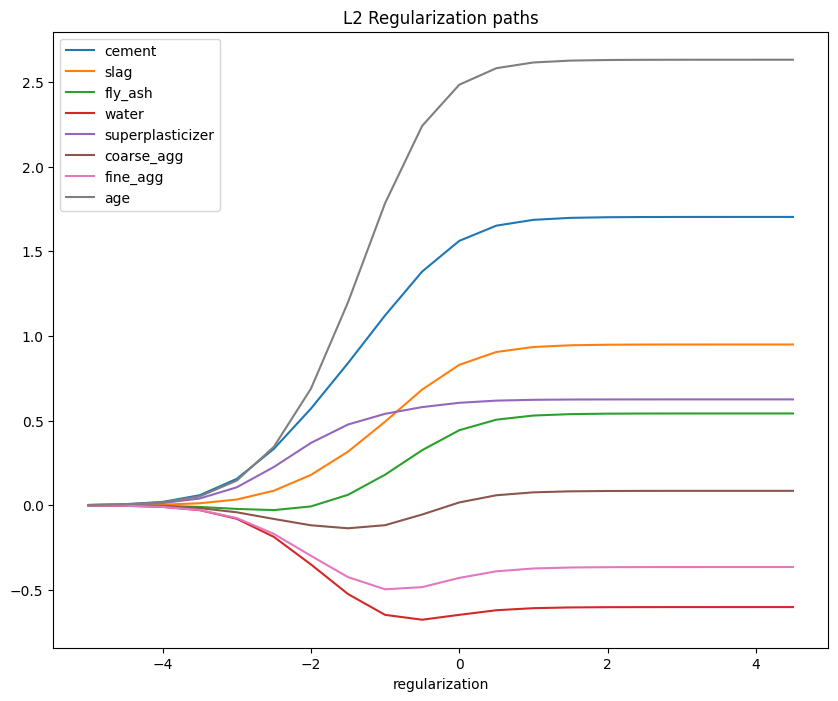

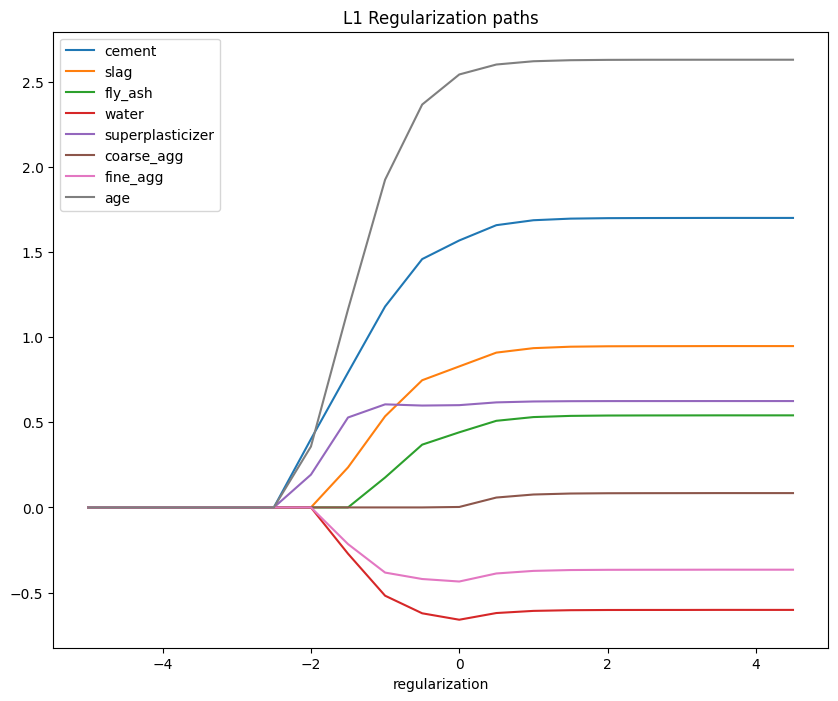

In [14]:
# Go through a bunch of ascending regularization parameters
regs = np.arange(-5, 5, 0.5)
# Get coefficients
l2_coefs = get_lr_regularization_paths(X_scaled, Y, "l2", regs)
l2_coefs.plot()
plt.title("L2 Regularization paths")
l1_coefs = get_lr_regularization_paths(X_scaled, Y, "l1", regs)
print(l1_coefs)
l1_coefs.plot()
plt.title("L1 Regularization paths")
plt.show()

### Hyper-parameter tuning

As seen previously, most models have a number of settings that impact their behavior and therefore generalization performance (such as the regularization settings we have seen today). A **different** way to use cross-validation (CV) is to tune these "hyper-parameters" (so-called because the coefficients in a model are also called "parameters").  I emphasize "different" above because these two different uses can confuse people when they start out, so to be clear: what we did last class was to use CV to **evaluate** models on holdout data.  What we will do now is to use CV to split up the *training* data in order to be able to choose hyperparameter values without tainting the holdout data. So we really are doing a second layer of holding out data.

So, we can choose several values for a particular hyper-parameter to try, use cross-validation to estimate model generalization performance for each, and save the hyperparameters that offered the best results.

For example, we could try different regularization settings and keep the one that produces the model with the highest accuracy.

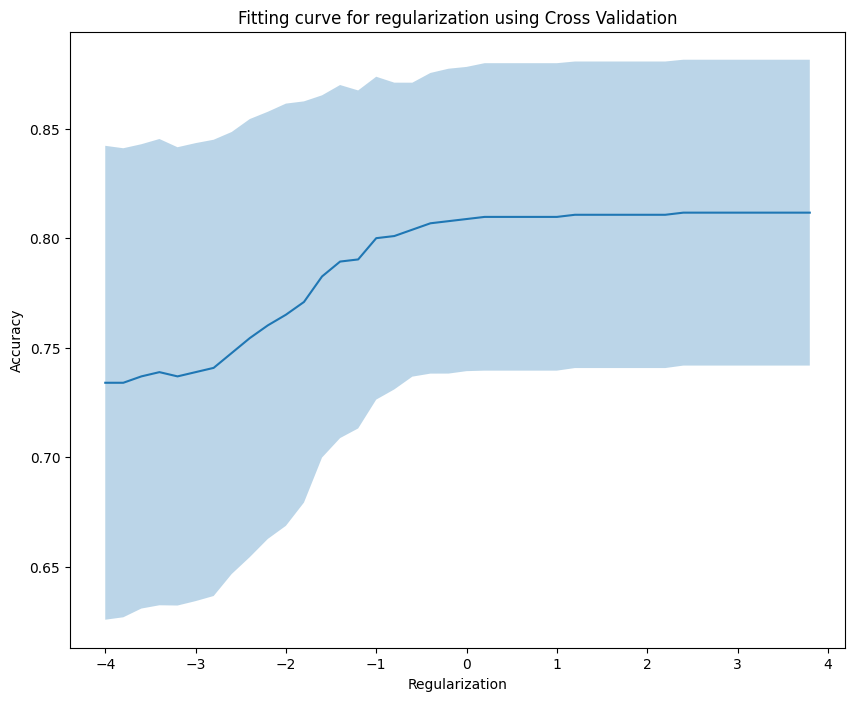

In [15]:
#For simplicity here we will presume that our data are all our training data and that we have a separate holdout set somewhere (but see Ch. 5's discussion of "nested" cross-validation)
from sklearn.model_selection import cross_val_score

folds = 10

def score_model(X, Y, model, scoring="accuracy"):
    scores = cross_val_score(model, X, Y, scoring=scoring, cv=folds)
    return {"mean": scores.mean(), "std_dev": scores.std()}

reg_vals = np.arange(-4, 4, 0.2)
scores_list = [score_model(X_scaled, Y, LogisticRegression(C=10**reg, solver='liblinear')) for reg in reg_vals]

accys = np.array([score["mean"] for score in scores_list])
# Confidence interval for the mean
accys_std = 1.96 * np.array([score["std_dev"] for score in scores_list]) / np.sqrt(folds)

plt.plot(reg_vals, accys)
plt.fill_between(reg_vals, accys + accys_std, accys - accys_std, alpha=0.3)
plt.xlabel("Regularization")
plt.ylabel("Accuracy")
plt.title("Fitting curve for regularization using Cross Validation")
plt.show()

In [16]:
#And what regularization value gave the best "cross-validated" accuracy?
reg_accs = pd.DataFrame(reg_vals, columns=['reg_val'])
reg_accs['accy'] = accys
reg_accs

,reg_val,accy
0,-4.000000e+00,0.733981
1,-3.800000e+00,0.733981
2,-3.600000e+00,0.736893
3,-3.400000e+00,0.738835
4,-3.200000e+00,0.736893
5,-3.000000e+00,0.738835
6,-2.800000e+00,0.740777
7,-2.600000e+00,0.747573
8,-2.400000e+00,0.754369
9,-2.200000e+00,0.760194


### Grid Search: tuning many hyper-parameters

The concept explored above can be extended in a very natural way to simultaniuosly optimize many hyper-parameters using a technique called "grid search". One first defines a "grid" of hyper-parameter values to explore. Basic grid search tries all possible combinations of these settings, selecting the setting with the best cross-validated value of the chosen generalization measure.

Sklearn provides a convenient implementation.

In [17]:
from sklearn.model_selection import GridSearchCV

grid = {"polynomial_features__degree": [1, 2, 3], "model__C": [10.0**c for c in np.arange(-2, 3)]}

def Polynomial_Model(degree=1, reg=1):
    return get_polynomial(degree=degree, model=LogisticRegression(C=reg, solver='liblinear', max_iter=1000))

# gridsearchcv behaves just like a model object, with fit & predict methods, and some additional functionalities
tuned_model = GridSearchCV(Polynomial_Model(), grid, scoring="accuracy", cv=10, verbose=1)
tuned_model.fit(X_scaled, Y)

print ("Best accuracy: %0.3f, using: " % tuned_model.best_score_)
print (tuned_model.best_params_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best accuracy: 0.830, using: 
{'model__C': 100.0, 'polynomial_features__degree': 2}


Let's take a look at the performance over our parameter grid.

In [18]:
from mpl_toolkits.mplot3d import Axes3D

means = tuned_model.cv_results_['mean_test_score']
stds = tuned_model.cv_results_['std_test_score']
params = tuned_model.cv_results_['params']

degrees = [param["polynomial_features__degree"] for param in params]
reg_vals = [np.log10(param["model__C"]) for param in params]

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(degrees, reg_vals, means, linewidth=0.1, cmap=plt.cm.coolwarm)
ax.set_xlabel('degrees')
ax.set_ylabel('regularization')
ax.set_zlabel('accuracy')
plt.show()

<Figure size 1000x800 with 0 Axes>

**A word of caution: ** Grids with many potential values combined with slow-ish model training can really blow up the time it takes to tune a model!

Also, just to reiterate: both of the hyper-parameters we just tuned are used to control complexity. It's very difficult to manage multiple complexity dimensions without automated complexity control.

### Learning curves for model assessment

Throughout the past lectures we analyzed and compared model accuracies using some particular **sample size** that was essentially fixed and determined by some choice(s) that we did not discuss (for the class demonstrations, basically the size of the dataset we obtained).

However, as we've mentioned repeatedly in class: you shouldn't be thinking about "getting a dataset", but about acquiring data.  Investing in data assets.

Very often we also want to assess the relationship between how much data we are using to train the models, and the generalization performance we achieve.  For example, do we have a good idea whether we should invest in acquiring more training data?  Or maybe we can discard some data from training to speed up learning (when we have a huge amount).

The only way to answer this question is again, experiment with different sample sizes. The main tool to help us with this assessment is the **_learning curve_**.  Learning curves visualize the change of the generalization performance (accuray on the holdout data, in this case) based on different sizes of the training set.

What would we expect to see? Holding everything else fixed, the generalization should be better with more training data, up until a certain point. Then, more data won't increase generalization performance.

In [19]:
import sklearn.model_selection as cv
from sklearn.metrics import accuracy_score

def evaluate_model_on_sample(X, Y, model, pct, scoring=accuracy_score):
    kf = cv.StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, test_index in kf.split(X, Y):
        # only take a portion of the training data
        train_size = len(train_index)
        sampled_indices = np.random.permutation(train_index)[:int(pct*train_size)]
        model.fit(X.iloc[sampled_indices], Y[sampled_indices])
        scores.append(scoring(Y[test_index], model.predict(X.loc[test_index])))
    return np.mean(scores)

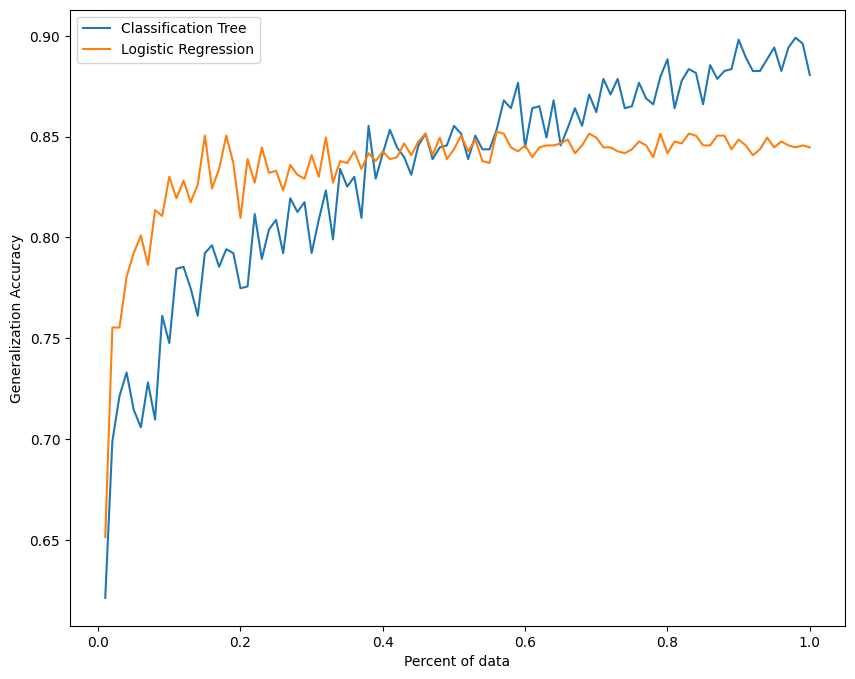

In [20]:
from sklearn.tree import DecisionTreeClassifier

pcts = np.linspace(0.01,1,100).tolist()
# Get scores for each classifier
dt_scores = [evaluate_model_on_sample(X, Y, DecisionTreeClassifier(), pct) for pct in pcts]
lr_scores = [evaluate_model_on_sample(X, Y, LogisticRegression(solver='liblinear'), pct) for pct in pcts]
# Plot without confidence interval
plt.plot(pcts, dt_scores, label="Classification Tree")
plt.plot(pcts, lr_scores, label="Logistic Regression")
plt.xlabel("Percent of data")
plt.ylabel("Generalization Accuracy")
plt.legend()
plt.show()

You might wonder about the choppiness of that learning curve.  The most straightforward way to smooth it is to run multiple runs of CV and average the curves.  It takes a while to run, but here's what you get when you run the above 10 times and average the curves:

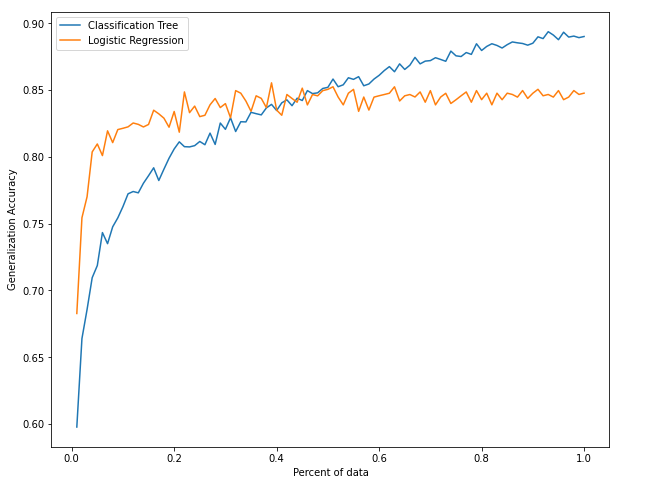

As we can see, learning curves can help us to determine at least 2 things:

- We can see which model performs better or worse for each sample size (e.g. Classification Tree vs Logistic Regression)
- We can get a sense of whether getting more data (or using less) will improve (or not degrade) generalization.

Very often, the more data we have, the more "complex" models we can use (as we have seen), so we really would want to do grid search for each point on the learning curve!  (We did not do that above, but you could try it!)